# Street View House Number Classification Capstone Project

This is the final project of the Udacity Introduction to Deep Learning course.  It is also submitted, as was suggested in the project description, as the capstone project for the Machine Learning Nanodegree.

## Project Purpose

House number classification is important for digital map-making _(Goodfellow, et. al. 2013)_.  It is also an interesting application of deep learning given that house numbers can be of variable length, consisting of one or more digits, so the problem differs from identifying a single most likely class from n potential classes like other image classification challenges.  Here there are two types of labels, the length of the house number and a varying number of individual digits at each decimal position in the house number.  It begs the question of whether a deep neural network can be fed some arbitrary form of inputs and labels and then yields after training sufficient inference regardless of the form of the data.

This is a very powerful idea that I would like to explore through several network architectures of increasing complexity to study the efficacies of various neural network architectural elements on the two types of inputs present here, namely the novel sequence length identification in combination with the well-applied digit classification.

## Data Exploration

We start as we always do with rummaging through the available training and testing data to see what we have.  The data that will be used here is the Stanford Street View House Number dataset _(Netzer, et. al. 2011)_.  This dataset provides house number images of varying sizes with labels and digit bounding box data in the H5P data format.

### Label Processing

Let start by loading in the labels.  For this dataset, the labels are provided in the accompanying digitStruct.mat file, along with the bounding boxes. This file is in H5P format. I am not familiar with how to process data from this file so I googled for code examples. I found a good implementation at https://github.com/prijip/Py-Gsvhn-DigitStruct-Reader (MIT license) that I slightly modified for my purposes. Reading in some data format is equivalent to using tools like pickle and don't add anything to the machine learning aspect of the project so I feel OK using someone else's code here.

In the code cell below I leveraged the digitStruct.py file to read the labels into a dictionary.  In the process, I will also include the length of the house number digit sequence in the label, per the approach used in _Goodfellow, et. al. 2013_, so that both model can be trained also on the sequence length.


In [24]:
from digitStruct import DigitStruct, yieldNextDigitStruct
from log_progress import log_progress

def read_labels(digitstruct_file, progress_size):
    """
    Read in labels from digitStruct.mat file to create a dict of image file name and 
    corresponding labels
    """        
    labels = dict()
    for dsObj in log_progress(yieldNextDigitStruct(digitstruct_file), size=progress_size):
        image_labels = []
        for bbox in dsObj.bboxList:
            image_labels.append(bbox.label)
        # Need to prepend the length of the digit sequence to the label for the image.
        full_label =[len(image_labels)]
        full_label.extend(image_labels)
        labels[dsObj.name] = full_label
    return labels

DSFILE = 'data/train/digitStruct.mat'
LABELS = read_labels(DSFILE, 33402)

OK that took awhile.  Let's save this to a pickle file so we don't have to do that again ever.

In [56]:
import os
import pickle
import numpy as np

def pickle_data(pickle_file, key_name, data):
    if not os.path.isfile(pickle_file):
        print('Saving data to pickle file', pickle_file)
        try:
            with open(pickle_file, 'wb') as pfile:
                pickle.dump({key_name : data}, pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
        print('Data saved successfully to', pickle_file)
    else:
        print('File', pickle_file, 'already exist!')

pickle_data('train_labels.p', 'labels', LABELS)

File train_labels.p already exist!


Let's also test reading the data back quickly to see if it's all OK.  If we need to backtrack later we can also just start here with this code to loa

In [58]:
LABELS = None

with open('train_labels.p', mode='rb') as f:    
    pdata = pickle.load(f)
    LABELS = pdata['labels']

def print_items_from_dict(dictionary, count):
    """
    Print out the first count items from a dictionary
    """
    i = 0
    for key, value in dictionary.items():
        print(key, value)
        i += 1
        if i >= count:
            break

print_items_from_dict(LABELS, 5)

10034.png [4, 2, 10, 2, 6]
14834.png [3, 1, 7, 3]
13237.png [2, 1, 5]
24485.png [2, 6, 7]
6589.png [2, 8, 10]


### Loading Images and Grayscale Conversion

Now we can load in the images in the order of the label list. At this point we should also consider whether color information is important for our classification purposes.  As with most digit recognition task, the shape of the digits rather than any color is the important feature.  Having color in the image could also confuse the model if some digit has an unbalanced color representation in the training data, and of course having three color channels instead of one grayscale channel will make training and evaluation more expensive.  For all these reasons, the code cell below will convert images to grayscale as they are being loaded.  In their work, _Goodfellow, et. al. 2013_ also noted that using grayscale images improved accuracy performance slightly.

In [47]:
from PIL import Image
import math
import glob
from log_progress import log_progress

IMAGE_NAMES = glob.glob('data/train/*.png')
IMAGE_COUNT = len(IMAGE_NAMES)
def load_svhn_images_by_labels(folder_path, labels=None):
    """
    Load in all images from a folder

    :param folder_path: Path to folder containing images.  Need to include trailing / in folder_path.
    :param labels: dictionary of labels read with _read_labels_ method.
    :return list of images in the order of matching labels
    """    
    images = []
    failures = []
    for file in log_progress(labels, size=len(labels)):
        file_path = folder_path + file
        try:
            image = Image.open(file_path).convert('L')
            image.load()
            # Load image data as 1 dimensional array
            # We're using float32 to save on memory space
            feature = np.array(image, dtype=np.float32)
            images.append(feature)
        except FileNotFoundError:
            failures.append(file)
    print("Successfully loaded {} files".format(len(images)))
    print("Failed to load {} files".format(len(failures)))
    return images

train_data_folder = 'data/train/'
IMAGES = load_svhn_images_by_labels(train_data_folder, LABELS)
HEIGHTS = [image.shape[0] for image in IMAGES]
WIDTHS = [image.shape[1] for image in IMAGES]

Successfully loaded 33402 files
Failed to load 0 files


Let's verify that the images and the labels all look correct.

10034.png [4, 2, 10, 2, 6]
14834.png [3, 1, 7, 3]
13237.png [2, 1, 5]
24485.png [2, 6, 7]
6589.png [2, 8, 10]


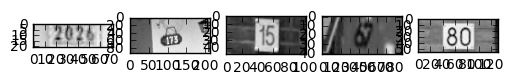

In [49]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from math import ceil
%matplotlib inline

def plot_images(X, rows, c_map='gray'):
    img_count = len(X)
    plot_cols = int(ceil(img_count / rows))
    f, img_plots = plt.subplots(rows, plot_cols, sharex=False)
    index = 0
    for r in range(rows):
        for c in range(plot_cols):
            if rows == 1:
                img_plots[c].imshow(X[index].squeeze(), cmap=c_map)
            else:
                img_plots[r, c].imshow(X[index].squeeze(), cmap=c_map)
            index += 1
            if index >= len(X):
                break

print_items_from_dict(LABELS, 5)
plot_images(IMAGES[0:5], 1)

**Note:** The first number in the label is the sequence length.  

Looks like all the labels are correct with the corresponding image, except that the digit 0 is labeled as 10.  As long as that's consistent, the training, testing, and subsequent transcription should all be fine.

### Width and Height Distributions

Because the images are all of different sizes, they will need to be resized to a single dimension as input into the neural network for training and evaluation.  To pick a reasonable common size, the distribution of image sizes needs to be looked at.  This is done in the following code cell.

In [50]:
print()
print("Training Image Count:", len(IMAGES))
MAX_HEIGHT, MIN_HEIGHT, MEAN_HEIGHT = max(HEIGHTS), min(HEIGHTS), sum(HEIGHTS) / float(len(HEIGHTS))
MAX_WIDTH, MIN_WIDTH, MEAN_WIDTH = max(WIDTHS), min(WIDTHS), sum(WIDTHS) / float(len(WIDTHS))
print()
print("Max Height:", MAX_HEIGHT, "Min Height:", MIN_HEIGHT, "Mean Height: {:.2f}".format(MEAN_HEIGHT))
print("Max Width: ", MAX_WIDTH, "Min Width: ", MIN_WIDTH, "Mean Width:  {:.2f}".format(MEAN_WIDTH))


Training Image Count: 33402

Max Height: 501 Min Height: 12 Mean Height: 57.21
Max Width:  876 Min Width:  25 Mean Width:  128.28


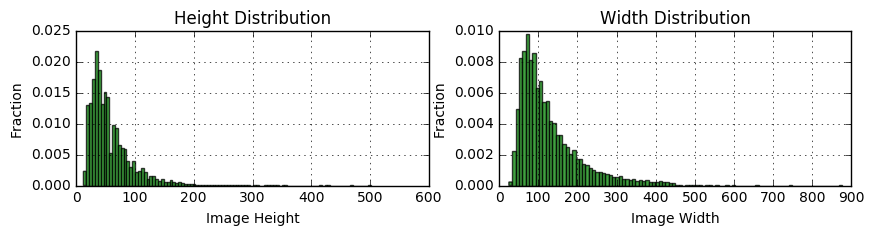

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

# setup heights histogram
def plot_heights_widths(heights, widths):
    fig = plt.figure(figsize=(10,2))
    height_plot = fig.add_subplot(121)

    l = height_plot.hist(heights, 100, normed=1, facecolor='green', alpha=0.75)

    height_plot.set_xlabel('Image Height')
    height_plot.set_ylabel('Fraction')
    height_plot.set_title('Height Distribution')
    height_plot.grid(True)

    width_plot = fig.add_subplot(122)

    l = width_plot.hist(widths, 100, normed=1, facecolor='green', alpha=0.75)

    width_plot.set_xlabel('Image Width')
    width_plot.set_ylabel('Fraction')
    width_plot.set_title('Width Distribution')
    width_plot.grid(True)

    plt.show()
    
plot_heights_widths(HEIGHTS, WIDTHS)

### Resizing All Images to Same Size

Now that we have sense of how large the images are, we need to scale them all to one size.  With a mean of 57 height and 128 width, I am thinking 64 height and 128 width (64x128) is a good size that should preserve sufficient details for training and testing.  The majority of the images will be scaled up at this size, and data loss from scaling down the larger images shouldn't be too bad.  Resizing is done by the code cell below.

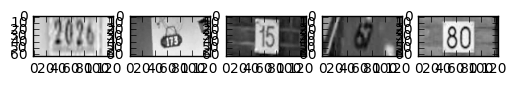

In [60]:
from scipy.misc import imresize

INPUT_SIZE = (64,128)

def resize_images(images, image_size):
    train_images = []
    for image in log_progress(images, size=len(images)):
        image = imresize(image, new_size, interp='cubic')
        train_images.append(image)
    return train_images

TRAIN_IMAGES = resize_images(IMAGES, INPUT_SIZE)
plot_images(TRAIN_IMAGES[0:5], 1)

### Saving the Training Images

Now that we have our training images in the desired form, let's pickle them so we don't have to do all that processing again.  

**Note:** I am purposefully not normalizing or separating the training data into a validation set before pickling.  I want to try different things with both normalization and building validation set so will be doing so later.  Saving and restoring the training images is in the code cell below.

Saving data to pickle file train_images.p
Data saved successfully to train_images.p


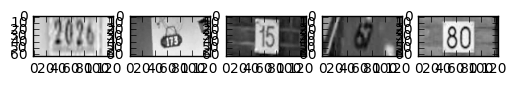

In [61]:
pickle_data('train_images.p', 'features', TRAIN_IMAGES)
del TRAIN_IMAGES

with open('train_images.p', mode='rb') as f:    
    pdata = pickle.load(f)
    TRAIN_IMAGES = pdata['features']

plot_images(TRAIN_IMAGES[0:5], 1)

### Bounding Box Data

One notable feature of this dataset is that digit bounding boxes are available. The image below shows the bounding box data superimposed over some house number images (from http://ufldl.stanford.edu/housenumbers/):

<img src="http://ufldl.stanford.edu/housenumbers/examples_new.png" width="400">

The bounding box data provides the option of just using the part of the image containing the house number digit as input data.  However, in general this will add enormous cost for manual labeling in the real world, and our model should be robust to scale and translation, so we'll start by using the entire image and ignore the bounding box information for now.

### Sequence Length Distribution

I am also curious about the distribution of house number lengths (i.e. the number of digits in the house numbers).  This will affect the number of outputs that the deep learning network will have.  The code cell below plots the distribution of sequence length.

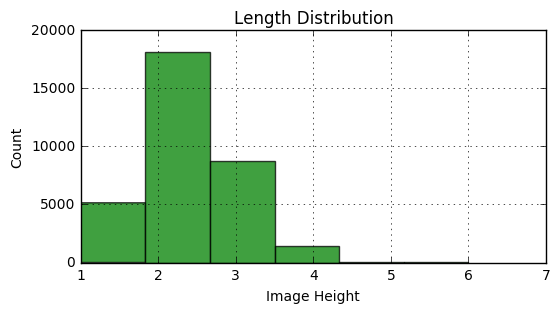

In [102]:
# Extract the sequence length from the label data
LENGTHS = [label[0] for key, label in LABELS.items()]

# setup heights histogram
def plot_lengths_histogram(lengths, bin_count):
    fig = plt.figure(figsize=(6,3))
    length_plot = fig.add_subplot(111)

    n, bins, patches = length_plot.hist(lengths, bin_count, facecolor='green', alpha=0.75)

    length_plot.set_xlabel('Image Height')
    length_plot.set_ylabel('Count')
    length_plot.set_title('Length Distribution')
    length_plot.grid(True)

    plt.show()
    
    return n

BIN_SIZES = plot_lengths_histogram(LENGTHS, 6)

Per the above plot, we have mostly sequences of 2 to 3 digits in length.  There are probably a very small number of house numbers with 5 digits.  We'll verify this by printing out the sizes of the bins.

In [100]:
for digit_count, bin in enumerate(BIN_SIZES):
    print(digit_count + 1, 'digit bin size: ', bin.item())

1 digit bin size:  5137.0
2 digit bin size:  18130.0
3 digit bin size:  8691.0
4 digit bin size:  1434.0
5 digit bin size:  9.0
6 digit bin size:  1.0



### Test Data Pre-processing

Now we'll load up and pre-process the test data just like how the training data was pre-processed above.

In [66]:
TEST_IMAGE_NAMES = glob.glob('data/test/*.png') 
TEST_IMAGE_COUNT = len(TEST_IMAGE_NAMES) 
TEST_DSFILE = 'data/test/digitStruct.mat' 
TEST_LABELS = read_labels(TEST_DSFILE, TEST_IMAGE_COUNT) 
TEST_IMAGES = resize_images(load_svhn_images_by_labels('data/test/', TEST_LABELS), INPUT_SIZE)

Successfully loaded 13068 files
Failed to load 0 files


3933.png [1, 5]
6022.png [2, 3, 1]
4059.png [1, 4]
6786.png [2, 2, 1]
10034.png [2, 9, 9]
File test_labels.p already exist!
File test_images.p already exist!


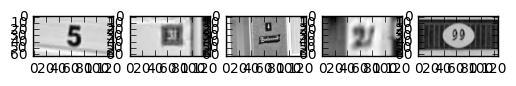

In [67]:
# Validate data
print_items_from_dict(TEST_LABELS, 5)
plot_images(TEST_IMAGES[0:5], 1)

# Pickle test data
pickle_data('test_labels.p', 'labels', TEST_LABELS)
pickle_data('test_images.p', 'features', TEST_IMAGES)

del TEST_LABELS
del TEST_IMAGES

3933.png [1, 5]
6022.png [2, 3, 1]
4059.png [1, 4]
6786.png [2, 2, 1]
10034.png [2, 9, 9]


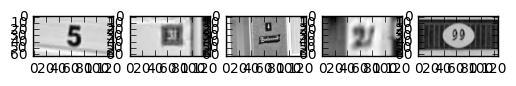

In [68]:
# Restore and validate
with open('test_labels.p', mode='rb') as f:    
    pdata = pickle.load(f)
    TEST_LABELS = pdata['labels']
    
with open('test_images.p', mode='rb') as f:    
    pdata = pickle.load(f)
    TEST_IMAGES = pdata['features']
    
print_items_from_dict(TEST_LABELS, 5)
plot_images(TEST_IMAGES[0:5], 1)

### Test Data Visualization

Let's just reproduce the sequence length distribution plot for the test data to see what it looks like.  It's somewhat similar in that nearly all of the sequences are 2-4 digits in length.

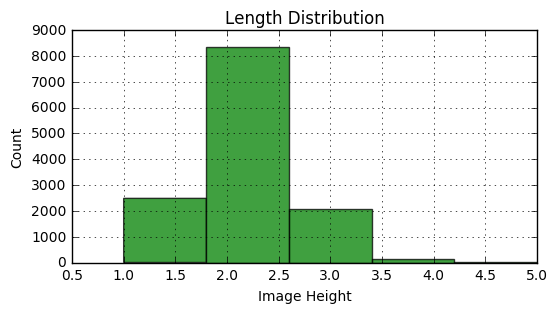

1 digit bin size:  2483.0
2 digit bin size:  8356.0
3 digit bin size:  2081.0
4 digit bin size:  146.0
5 digit bin size:  2.0


In [103]:
TEST_LENGTHS = [label[0] for key, label in TEST_LABELS.items()]

BIN_SIZES = plot_lengths_histogram(TEST_LENGTHS, 5)

for digit_count, bin in enumerate(BIN_SIZES):
    print(digit_count + 1, 'digit bin size: ', bin.item())

## Summary

In summary, with our data exploration and preprocessing we took the following steps:

* Loaded in the training image data and labels
* Added the sequence length to the label for training and testing
* Explained why grayscale should be sufficient and converted all images to grayscale
* Looked at the image size distribution and statistics in the training data
* Selected a single input image size to use for all images.
* Verified that the labels and images match up
* Looked at the distribution of digit sequence lengths for the house numbers
* Saved the processed training images and labels to pickle files.
* Decided to not use the bounding box information for now.
* Loaded in and pre-processed the testing data (grayscale, resizing, length addition to the label, etc.)
* Verified that the labels and images match.
* Looked at the sequence length distribution of the testing data.
* Saved the processed testing images and labels to pickle files.

## References

"Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks", _Ian J. Goodfellow, Yaroslav Bulatov, Julian Ibarz, Sacha Arnoud, Vinay Shet_, Google Inc., Mountain View, CA

"Reading Digits in Natural Images with Unsupervised Feature Learning", _Yuval Netzer 1 , Tao Wang 2 , Adam Coates 2 , Alessandro Bissacco 1 , Bo Wu 1 , Andrew Y. Ng 1,2_, 1: Google Inc., Mountain View, CA, 2: Stanford University, Stanford, CA
